In [1]:
from dataloader import *
from model import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd

2024-01-11 19:03:11.641862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 19:03:11.778383: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 19:03:14.332881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-11 19:03:14.333201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

## Load data

In [2]:
ecl_data = pd.read_csv('data/electricity.csv', header=None).to_numpy()

In [3]:
batch_size = 32
n_train = 18317
n_eval = 2633
n_test = 5261
train_loader, eval_loader, test_loader = get_loaders(ecl_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Train

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
writer = SummaryWriter()

cuda


In [5]:
N = 321 #nb variables
T = 96 #input length (lookback window)
D = 512 # 256 ou 512
S = 96 # 96 ou 192, 336, 720
proj_dim = 512
num_blocks = 2 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, proj_dim, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-4, weight_decay = 1e-5) #10−3, 5 × 10−4, 10−4 



In [6]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device, writer)

---- epoch :  0
loss train : 0.2771764851975859
loss eval : 0.16181856915354728
---- epoch :  1
loss train : 0.2472872191615272
loss eval : 0.15015282947570086
---- epoch :  2
loss train : 0.2388763935680975
loss eval : 0.14390736427158118
---- epoch :  3
loss train : 0.23423752057970615
loss eval : 0.14260834837332367
---- epoch :  4
loss train : 0.2308704841032363
loss eval : 0.14123520907014608
---- epoch :  5
loss train : 0.22843042000343924
loss eval : 0.13910330599173903
---- epoch :  6
loss train : 0.22637725757402286
loss eval : 0.1359065083786845
---- epoch :  7
loss train : 0.22452111215445034
loss eval : 0.13542093727737664
---- epoch :  8
loss train : 0.22312548160552978
loss eval : 0.13580022854730486
---- epoch :  9
loss train : 0.2215066614381054
loss eval : 0.1351293683052063


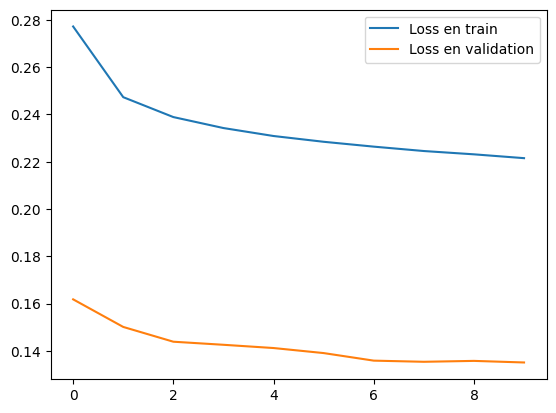

In [7]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [8]:
loss_test, loss_mae, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)
print("MAE : ", loss_mae)

MSE :  0.15544327770201666
MAE :  0.2557874502813291


Affichage pour une modalité sur toute la durée de la prédiction

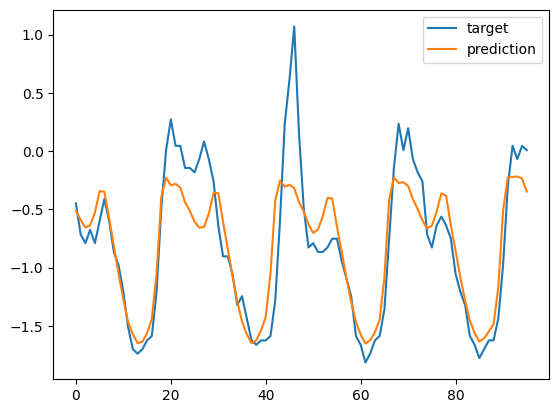

In [9]:
i = 1
plt.figure()
plt.plot(target[0,:,i].to("cpu"),label="target")
plt.plot(yhat[0,:,i].to("cpu"),label="prediction")
plt.legend()
plt.show()

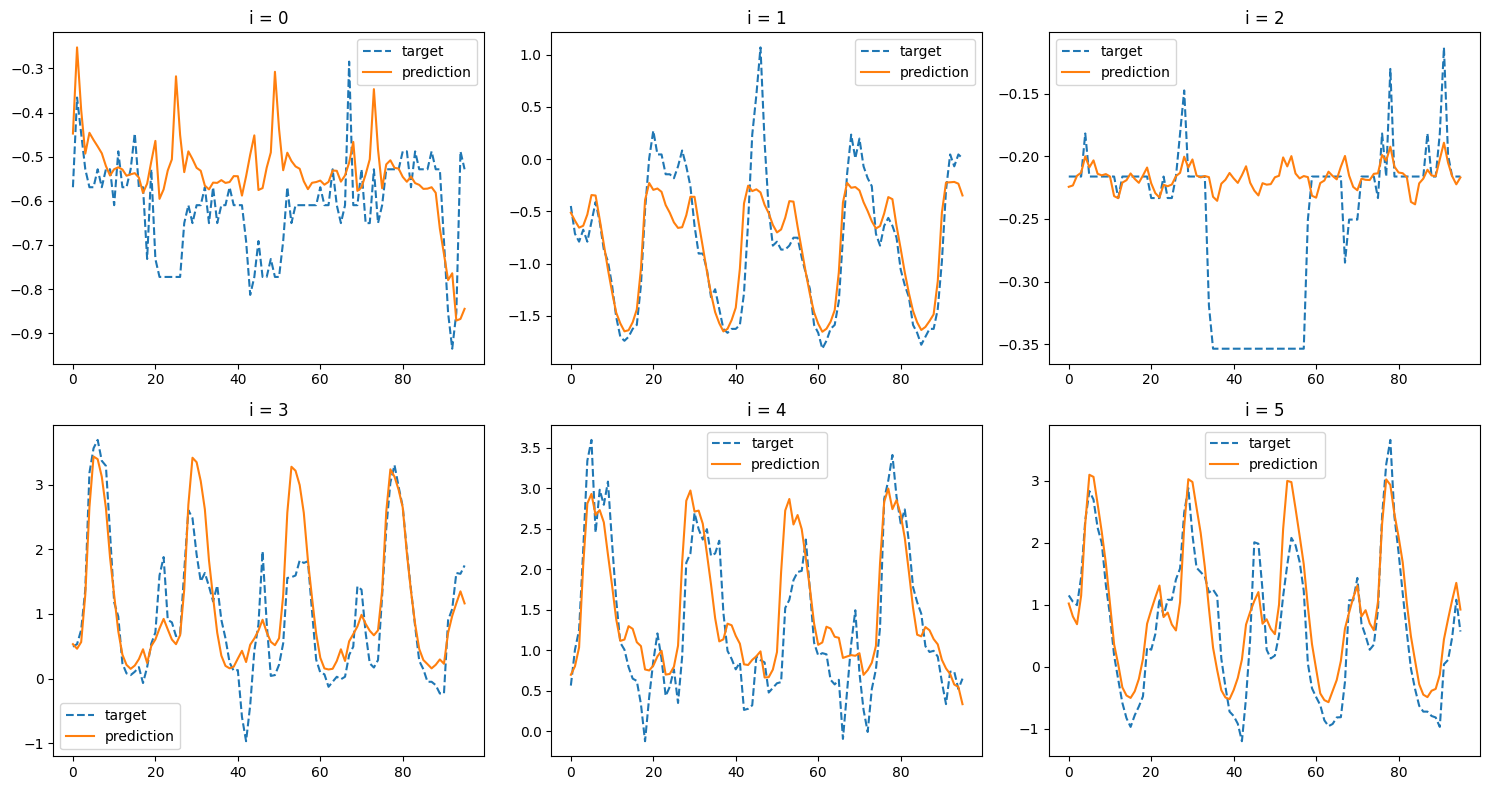

In [10]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    current_i = i - 1
    
    plt.plot(target[0, :, current_i].to("cpu"), "--", label="target")
    plt.plot(yhat[0, :, current_i].to("cpu"), label="prediction")
    
    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()

Affichage de toutes les modalités à un instant t

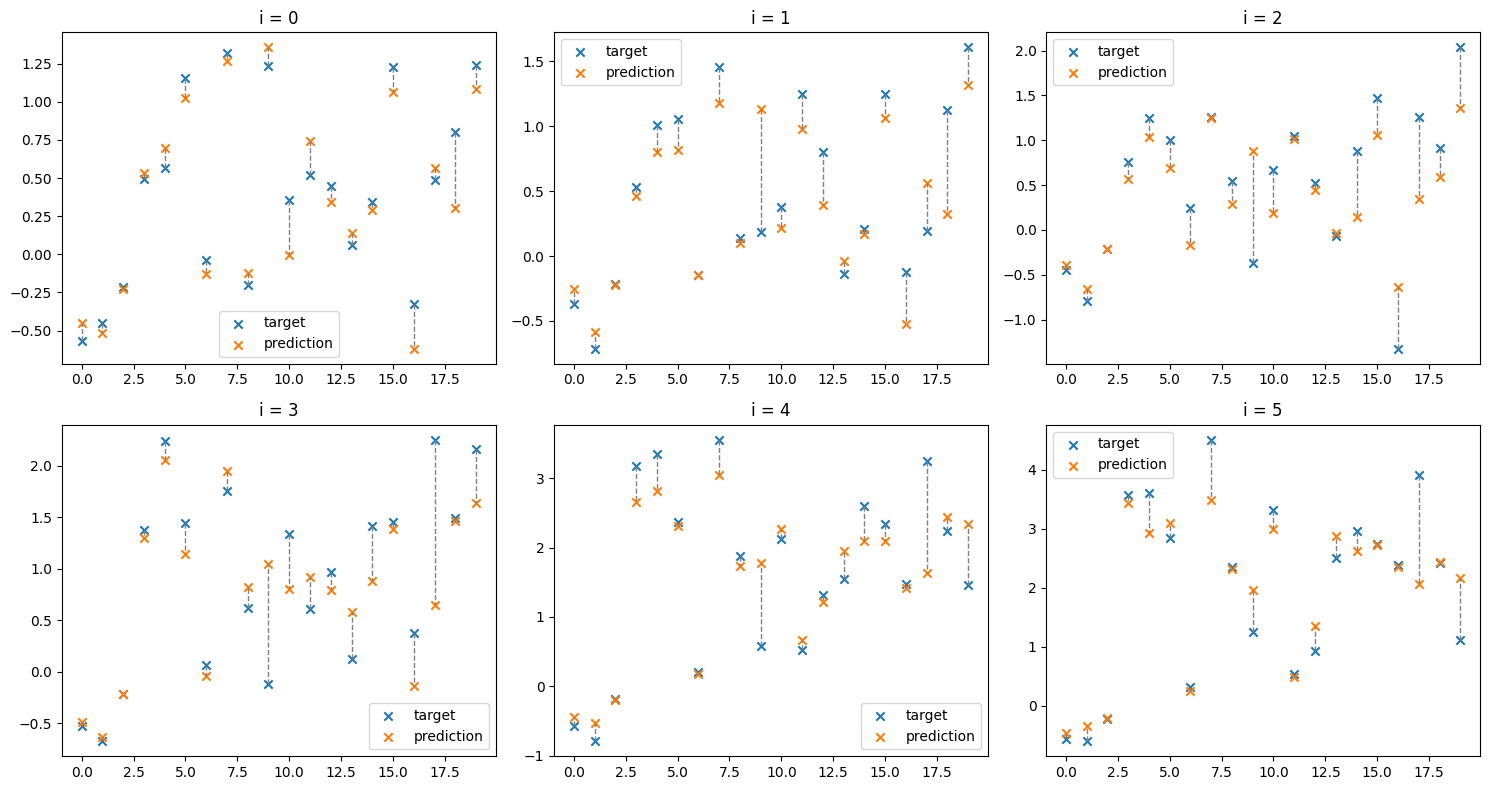

In [11]:
plt.figure(figsize=(15, 8))

for i in range(1, 7):
    plt.subplot(2, 3, i)
    
    current_i = i - 1
    
    plt.scatter(np.arange(len(target[0, current_i, :20])), target[0, current_i, :20].to("cpu"), marker='x', label="target")
    plt.scatter(np.arange(len(target[0, current_i, :20])), yhat[0, current_i, :20].to("cpu"), marker='x', label="prediction")

    for j in range(len(target[0, 0, :20])):
        plt.plot([j, j], [target[0, current_i, j].to("cpu"), yhat[0, current_i, j].to("cpu")], color='gray', linestyle='--', linewidth=1)

    plt.title(f"i = {current_i}")
    plt.legend()

plt.tight_layout()
plt.show()